In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

# ee.Initialize()

0.34.1


In [3]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)


##FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [4]:
#L5
L5_low = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_20020108')))
L5_mid = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19991202')))
L5_high = addFLATSL5(maskL5sr(ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_20011020')))

#L7
L7_low = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_016038_20020508')))
L7_mid = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_017038_20020616')))
L7_high = addFLATSL7(maskL5sr(ee.Image('LANDSAT/LE07/C02/T1_L2/LE07_016038_20020201')))

#L8
L8_low = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016038_20201211')))
L8_mid = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016038_20220320')))
L8_high = addFLATSL8(maskL5sr(ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_017038_20201116')))

#L9
L9_low = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20211229')))
L9_mid = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20220130')))
L9_high = addFLATSL9(maskL5sr(ee.Image('LANDSAT/LC09/C02/T1_L2/LC09_017038_20220303')))

In [59]:
##Draw geometry for exported images! It will look better
bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)
Map.addLayer(bb)
# Map

In [31]:
#Directory
out_dir = os.path.join("F:/Flats imagery")

In [66]:
gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

image = L8_high
filename = os.path.join(out_dir, 'l8high.tif')

image = image.clip(bb).unmask() ##CHANGED TO BOUNDING BOX

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

In [67]:
import geopandas as gpd
import rasterio


In [68]:
l5low_path = 'F:/Flats imagery/l5low.flats.tif'
l5mid_path = 'F:/Flats imagery/l5mid.flats.tif'
l5high_path = 'F:/Flats imagery/l5high.flats.tif'

l5_paths = [l5low_path,l5mid_path,l5high_path]

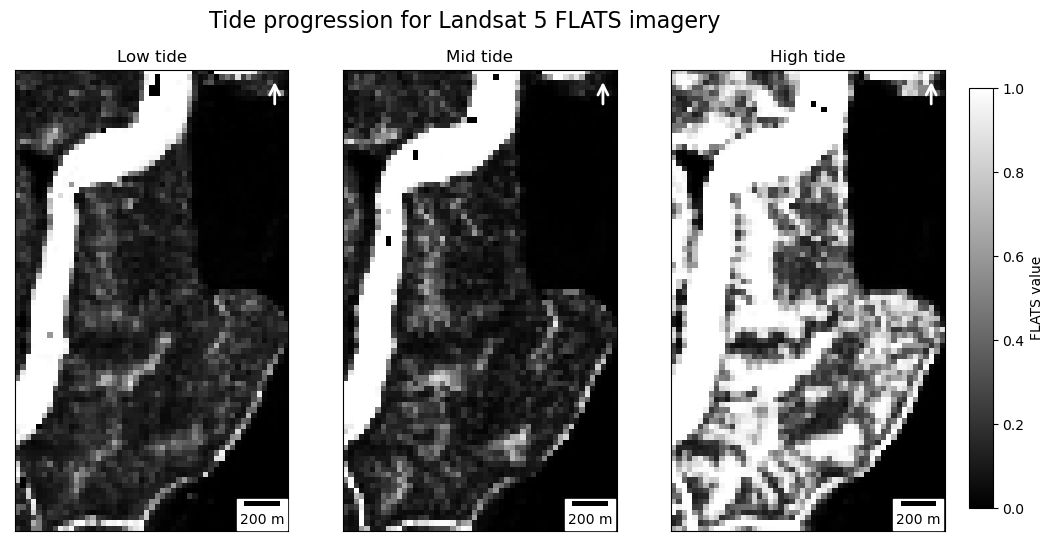

EPSG:32617


In [89]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import numpy as np

#Calculating dx for scale_bar - DX IS 1; UTM PROJ
# from geopy.distance import great_circle
# point1 = (31.425,-81.29) 
# point2 = (31.425,-80.29)  
# dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 0.5  # Experiment with different gamma values
        data = data ** gamma
        
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin = 0, vmax = 1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=1, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object


# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['Low tide', 'Mid tide', 'High tide']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs):
    im = plot_geotiff_with_scale_and_north_arrow(l5_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
plt.suptitle('Tide progression for Landsat 5 FLATS imagery', fontsize=16)

##Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'FLATS value', cmap = \
                          colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')]))

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('l5trimap.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

src = rasterio.open(l5low_path)
print(src.crs)

In [43]:
l8low_path = 'F:/Flats imagery/l8low.flats.tif'
l8mid_path = 'F:/Flats imagery/l8mid.flats.tif'
l8high_path = 'F:/Flats imagery/l8high.flats.tif'

l8_paths = [l8low_path,l8mid_path,l8high_path]

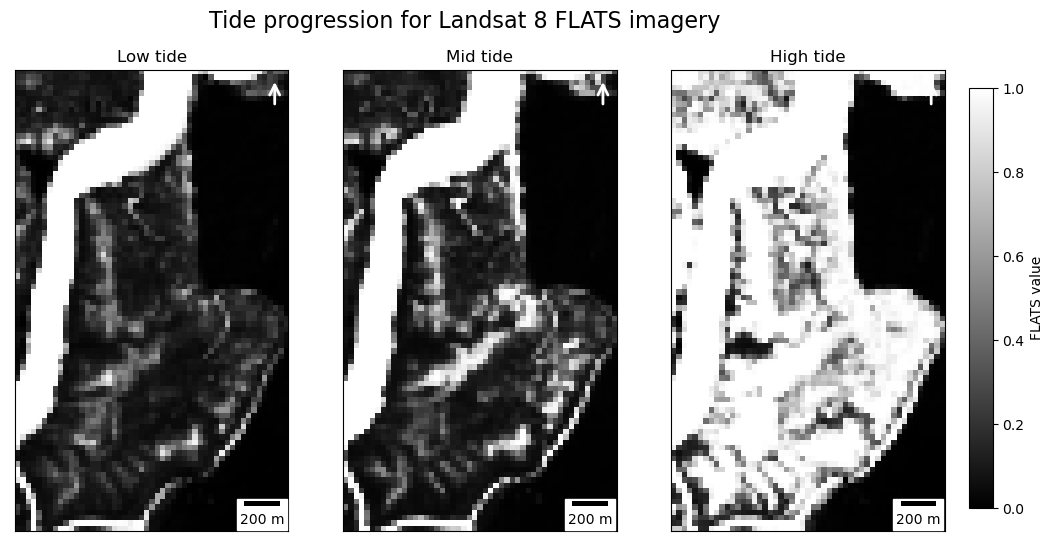

In [90]:
#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 0.5  # Experiment with different gamma values
        data = data ** gamma
        
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin = 0, vmax = 1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=1, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object


# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(1, 3, figsize=(12, 6))  # Increased figsize

# Initialize im objects
ims = []


# Define titles for each subplot
titles = ['Low tide', 'Mid tide', 'High tide']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs):
    im = plot_geotiff_with_scale_and_north_arrow(l8_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
plt.suptitle('Tide progression for Landsat 8 FLATS imagery', fontsize=16)

##Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'FLATS value', cmap = \
                          colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')]))

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('l8tripmap.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()


NameError: name 'l5low_path' is not defined

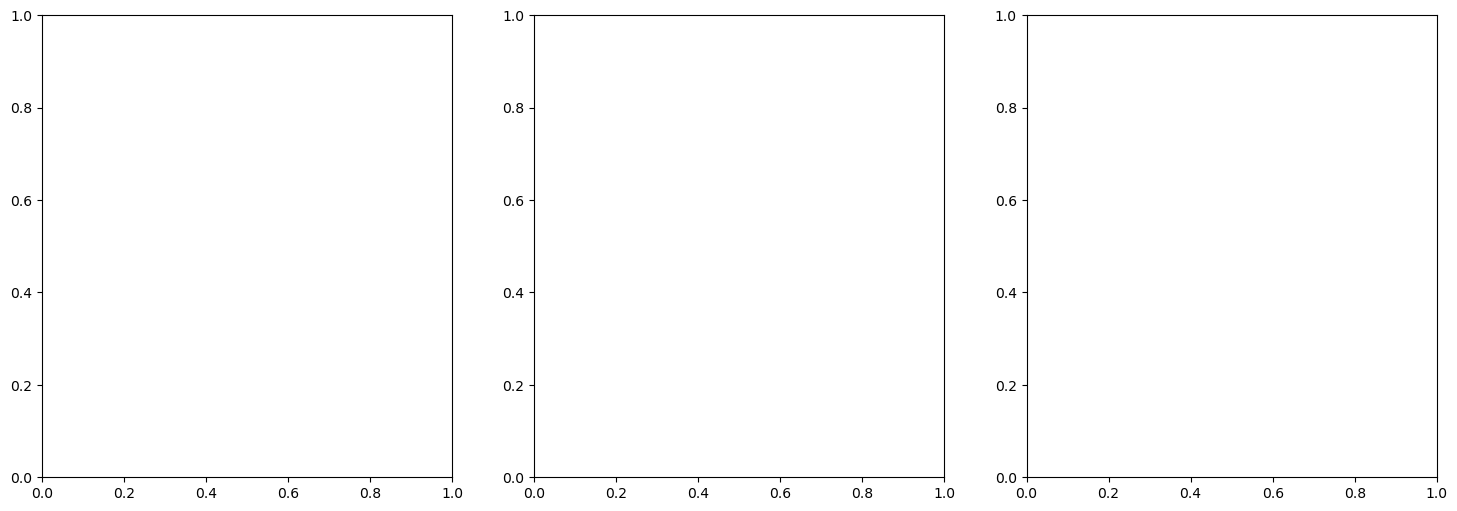

In [6]:
##COLORING FLATS

import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import numpy as np

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

        # Threshold for identifying values greater than 0.2
        threshold = 0.2

        # Create a custom colormap for the original black-and-white gradient
        cmap = colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'black'), (1, 'white')])

        # Plot the GeoTIFF data using imshow with the original colormap
        im = ax.imshow(data, extent=extent, cmap=cmap)

        # Create a mask for values greater than 0.2
        red_mask = data > threshold

        # Create a red overlay for pixels with 'flats' value > 0.2
        overlay = np.zeros_like(data)
        overlay[red_mask] = 1  # Set marked pixels to 1 (red)

        # Overlay the red marks on top of the original image with transparency
        ax.imshow(overlay, extent=extent, cmap='Reds', alpha=0)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(src.res[0], location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)

        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Increased figsize

# Define titles for each subplot
titles = ['Low tide', 'Mid tide', 'High tide']

# Plot each GeoTIFF image with its corresponding title
plot_geotiff_with_scale_and_north_arrow(l5low_path, axs[0], titles[0])
plot_geotiff_with_scale_and_north_arrow(l5mid_path, axs[1], titles[1])
plot_geotiff_with_scale_and_north_arrow(l5high_path, axs[2], titles[2])

# Add a title for the entire figure (optional)
plt.suptitle('Tide progression for Landsat 5 FLATS imagery', fontsize=16)

##Colorbar
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(axs[0].images[0], cax=cbar_ax, label='FLATS value', cmap='custom_gray')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('fig.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()
